In [ ]:
!pip install python-igraph --quiet

In [1]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

import pickle

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
# import igraph as ig

# Main computation libraries
import scipy.sparse as sp
from scipy.sparse import csr_matrix

import numpy as np

# Deep learning related imports
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive
%cd MyDrive
%cd REU-repo
%cd pytorch-GAT

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/REU-repo
/content/drive/MyDrive/REU-repo/pytorch-GAT


With that out of the way we've got the level 1 unlocked (Data 📜). 😍 Let's go!

# Part 1: Understanding your data (become One with the data 📜❤️)


In [4]:
# First let's define these simple functions for loading/saving Pickle files - we need them for Cora

# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

Now let's see how we can load Cora!

Nice, there are 2 more functions that I've used that we're yet to define. First let's see how we do **feature normalization** on Cora:

In [5]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

It's basically making Cora's binary node feature vectors sum up to 1. Example if we had `[1, 0, 1, 0, 1]` (Cora's feature vectors are longer as we'll soon see but let's take this one for the time being), it will get transformed into `[0.33, 0, 0.33, 0, 0.33]`. Simple as that. It's always harder to understand the actual implementation, but conceptually, it's a piece of cake.

That out of the way let's build up that **edge index**:

In [6]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

Nice! Analyzing the shapes we see the following:
1. Cora has 2708 nodes
2. Each node has 1433 features (check out [data_loading.py](https://github.com/gordicaleksa/pytorch-GAT/blob/main/utils/data_loading.py) for much more detail)
3. We have 13264 edges! (including the self edges)
4. We have 140 training nodes
5. We have 500 val nodes
6. We have 1000 test nodes

Additionally almost all of the data is of int 64 type. Why? Well it's a constraint that PyTorch is imposing upon us.
The loss function `nn.CrossEntropyLoss` and `index_select` functions require torch.long (i.e. 64 bit integer) - that's it.

* `node_labels` is int64 because of `nn.CrossEntropyLoss`
* other vars are int64 because of `index_select`

On the "side note", it's always a **good idea to test your code as you're progressing.**

Data loading is completely orthogonal to the rest of this notebook so we can test it, standalone, and make sure the shapes and datatypes make sense. I use this strategy while developing projects like this one (and in general).

I start with data, I add the loading functionality, I add some visualizations and only then do I usually start developing the deep learning model itself.

Visualizations are a huge bonus, so let's develop them.

# Visualizing your data 🔮👓

Let's start by understanding the degree distribution of nodes in Cora - i.e. how many input/output edges do nodes have, a certain measure of connectedness of the graph.

Run the following cell:

You can immediately notice a couple of things:
* The top 2 plots are the same, because we treat Cora as an undirected graph (even though it should naturally be modeled as a directed graph)
* Certain nodes have a huge number of edges (the peak in the middle) but most nodes have far less edges
* The third plot nicely visualizes this in the form of a histogram - most nodes have only `2-5` edges (hence the peak on the leftmost side)

Ok, we're starting to get some valuable insight into Cora, let's continue further and literally visualize/see Cora.

The following cell will plot Cora, run it. (*whispers: run it*)

# Part 2: Understanding GAT's inner workings 💻🦄

First let's create a high level class where we'll build up `GAT` from `GatLayer` objects.

It basically just stacks the layers into a nn.Sequential object and additionally since nn.Sequential expects a single input (and it has a single output) I just pack the data (features, edge index) into a tuple - *pure syntactic sugar*.

Now for the fun part let's define the layer.

I really don't think that I can explain it any better, using words, than you taking your time to digest the code and the comments.

Also make sure to check out [my video on GAT](https://www.youtube.com/watch?v=uFLeKkXWq2c) before you start losing time trying to figure it out "from scratch". It's always good to have some theoretical background at your hand.

# Part 3: Training GAT 💪 (Classification on Cora!)

Phew, well the hardest part is behind us. Let's know create a simple training loop where the goal is to learn to classify Cora nodes.

But first let's define some relevant constants.

In [7]:
from torch.utils.tensorboard import SummaryWriter
import enum
import os


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2


writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via accuracy metric), we'll break out from the training loop.
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

Also, let's define a couple of functions that will be useful while training the model.

The training state contains a lot of useful `metadata` which we can later use. You can imagine that saving the test accuracy of your model is important, especially when you're training your models on a cloud - it makes the organization so much better.

In [8]:
!pip install GitPython --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [9]:
import git
import re  # regex


def get_training_state(training_config, model):
    base_path = '/content/drive/MyDrive/REU-repo'
    repo_path = os.path.join(base_path, 'pytorch-GAT')

    training_state = {
        "commit_hash": git.Repo(repo_path, search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict just a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')


# This one makes sure we don't overwrite the valuable model binaries (feel free to ignore - not crucial to GAT method)
def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

Nice, now `argparse` is just a nice way to **organize** your program settings:

In [10]:
import torch

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device), strict=False)
    return model


In [11]:
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0  # this will likely change as soon as I add an inductive example (Cora is transductive)

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)  # I pack data into tuples because GAT uses nn.Sequential which requires it

    def get_node_indices(phase, batch_indices=None):
        if phase == LoopPhase.TRAIN:
            return batch_indices if batch_indices is not None else train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase, batch_indices=None):
        if phase == LoopPhase.TRAIN:
            return node_labels.index_select(node_dim, batch_indices) if batch_indices is not None else train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0, batch_indices=None):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase, batch_indices)
        gt_node_labels = get_node_labels(phase, batch_indices)  # gt stands for ground truth

        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward()  # compute the gradients for every trainable weight in the computational graph
            optimizer.step()  # apply the gradients to weights

        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)

        #
        # Logging
        #

        if phase == LoopPhase.TRAIN:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # Log to console
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            if patience_period is not None:
                if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                    BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC)  # keep track of the best validation accuracy so far
                    BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                    PATIENCE_CNT = 0  # reset the counter every time we encounter new best accuracy
                else:
                    PATIENCE_CNT += 1  # otherwise keep counting

                if PATIENCE_CNT >= patience_period:
                    raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy  # in the case of test phase we just report back the test accuracy

        return accuracy

    return main_loop  # return the decorated function


# CICIDS2017 dataset

In [12]:
"""
    Contains constants needed for data loading and visualization.
"""

import os
import enum
import zipfile
import pandas as pd

# Supported datasets - only CICIDS2017 in this notebook
class DatasetType(enum.Enum):
    CICIDS2017 = 0

# Networkx is not precisely made with drawing as its main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1

# Define the path to the data directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CICIDS2017_ZIP_PATH = os.path.join(DATA_DIR_PATH, 'archive.zip')
CICIDS2017_PATH = os.path.join(DATA_DIR_PATH, 'cic-ids2017')

# Ensure the data directory exists
if not os.path.exists(CICIDS2017_PATH):
    os.makedirs(CICIDS2017_PATH)

# List all CSV files in the CICIDS2017_PATH directory
csv_files = [f for f in os.listdir(CICIDS2017_PATH) if f.endswith('.csv')]

# Check if there are no CSV files
if not csv_files:
    print(f"No CSV files found in {CICIDS2017_PATH}.")
else:
    # Initialize an empty list to store DataFrames
    dfs = []

    # Read each CSV file and append to the list
    for csv_file in csv_files:
        file_path = os.path.join(CICIDS2017_PATH, csv_file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    data = pd.concat(dfs, ignore_index=True)

    # Strip any whitespace from the column names
    data.columns = data.columns.str.strip()

    # Basic information about the dataset
    print(f"Number of samples: {data.shape[0]}")
    print(f"Number of features: {data.shape[1] - 1}")  # Exclude the label column assuming it's the last one

    if 'Label' in data.columns:
        num_classes = data['Label'].nunique()  # Assuming 'Label' is the label column
        print(f"Number of classes: {num_classes}")
    else:
        print("No 'Label' column found in the dataset.")


Number of samples: 2830743
Number of features: 78
Number of classes: 15


In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import numpy as np
import os
import pandas as pd
import enum

def load_graph_data(training_config, device, data_fraction=1.0):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CICIDS2017.name.lower():
        # Use only a fraction of the data
        num_samples = int(len(data) * data_fraction)
        data_subset = data.iloc[:num_samples]

        # Map all attack labels to 'Anomaly'
        data.loc[:, 'Label'] = data['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Anomaly')
        # Fit the LabelEncoder on the entire dataset
        label_encoder = LabelEncoder()
        label_encoder.fit(data['Label'])
        num_classes = len(label_encoder.classes_)
        print("Unique classes:", label_encoder.classes_)

        # Encode labels
        data_subset.loc[:, 'Label'] = label_encoder.transform(data_subset['Label'])
        print("Encoded labels:", np.unique(data_subset['Label']))

        # Extract features and labels
        # labels = data_subset['Label'].astype('category')
        # unique_class_names = labels.cat.categories.values  # Get unique class names
        # print("Unique class names:", unique_class_names)
        # encoded_labels = labels.cat.codes.values
        # num_classes = len(labels.cat.categories)  # Calculate the number of unique classes
        # print("Encoded labels:", np.unique(encoded_labels))  # Print encoded labels to verify

        # Define the most important numerical features (excluding time-based features)
        numerical_features = [
            'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Total Fwd Packets', 'Total Backward Packets',
            'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Fwd Packet Length Max', 'Bwd Packet Length Max',
            'Packet Length Mean', 'Packet Length Std', 'Min Packet Length', 'Max Packet Length', 'SYN Flag Count',
            'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'RST Flag Count', 'Avg Fwd Segment Size',
            'Avg Bwd Segment Size', 'Fwd Header Length', 'Bwd Header Length', 'Average Packet Size'
        ]

        # Extract numerical data and scale it
        numerical_data = data_subset[numerical_features].values

        # Handle infinite values
        numerical_data = np.where(np.isinf(numerical_data), np.nan, numerical_data)

        # Replace NaNs with column mean
        col_mean = np.nanmean(numerical_data, axis=0)
        inds = np.where(np.isnan(numerical_data))
        numerical_data[inds] = np.take(col_mean, inds[1])

        scaler = StandardScaler()
        scaled_numerical_data = scaler.fit_transform(numerical_data)

        # Combine features
        features = scaled_numerical_data

        print("Features shape:", features.shape)
        print("Features dtype:", features.dtype)
        print("Any NaN values in features:", np.isnan(features).any())
        print("Any infinite values in features:", np.isinf(features).any())
        print("num_classes:", num_classes)


        # Create PyTorch tensors
        node_features = torch.tensor(features, dtype=torch.float32).to(device)

        # Create device mapping
        devices = set(data_subset['Destination Port'].values)
        devices.update(data_subset['Destination Port'].values)
        device_to_id = {device: idx for idx, device in enumerate(devices)}

        # Build edge list based on Destination Port
        source_nodes_ids, target_nodes_ids = [], []
        for index, row in data_subset.iterrows():
            src_device = device_to_id[row['Destination Port']]
            dst_device = device_to_id[row['Destination Port']]
            source_nodes_ids.append(src_device)
            target_nodes_ids.append(dst_device)
            target_nodes_ids.append(src_device)  # Assuming bidirectional connections
            source_nodes_ids.append(dst_device)

        edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

        # Convert to dense PyTorch tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long, device=device)
        node_labels = torch.tensor(data_subset['Label'].astype(int).values, dtype=torch.long).to(device)
        node_features = torch.tensor(features, dtype=torch.float32, device=device)

        # Define the new split percentages
        test_split = 0.5
        val_split = 0.3
        train_split = 0.2

        # Ensure the splits are taken from the 10% subset
        num_samples = node_features.shape[0]
        test_size = int(0.5 * num_samples)
        val_size = int(0.3 * num_samples)
        train_size = num_samples - test_size - val_size


        # Ensure splits sum up to the number of samples
        assert train_size + val_size + test_size == num_samples

        # Generate indices for the splits
        train_indices = torch.arange(train_size, dtype=torch.long, device=device)
        val_indices = torch.arange(train_size, train_size + val_size, dtype=torch.long, device=device)
        test_indices = torch.arange(train_size + val_size, num_samples, dtype=torch.long, device=device)

        return node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes
    else:
        raise Exception(f'{dataset_name} not yet supported.')

In [14]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    'dataset_name': DatasetType.CICIDS2017.name,
    'should_visualize': False
}

# Load the data
data_fraction = 0.1  # Use 10% of the dataset for example
node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes = load_graph_data(config, device, data_fraction=data_fraction)

# Print the shapes and types of the tensors
print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

Unique classes: ['Anomaly' 'Normal']
Encoded labels: [0 1]
Features shape: (283074, 23)
Features dtype: float64
Any NaN values in features: False
Any infinite values in features: False
num_classes: 2
torch.Size([283074, 23]) torch.float32
torch.Size([283074]) torch.int64
torch.Size([2, 566148]) torch.int64
torch.Size([56615]) torch.int64
torch.Size([84922]) torch.int64
torch.Size([141537]) torch.int64


In [15]:
!pip install torch-geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00


In [16]:
import time
# CIC dataset
import torch
import torch.nn as nn
from torch.optim import Adam
from torch_geometric.data import Data, DataLoader
from torch.utils.data import TensorDataset


class GATLayer(nn.Module):
    src_nodes_dim = 0
    trg_nodes_dim = 1
    # nodes_dim = 0
    head_dim = 1

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(), dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):
        super().__init__()
        self.nodes_dim = 0
        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat
        self.add_skip_connection = add_skip_connection
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)
        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)
        self.leakyReLU = nn.LeakyReLU(0.2)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)
        self.log_attention_weights = log_attention_weights
        self.attention_weights = None
        self.init_params()

    def forward(self, data):
        in_nodes_features, edge_index = data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'
        in_nodes_features = self.dropout(in_nodes_features)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        nodes_features_proj = self.dropout(nodes_features_proj)
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        attentions_per_edge = self.dropout(attentions_per_edge)
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)
        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)
        # print(f"trg_index_broadcasted shape: {trg_index_broadcasted.shape}")
        # print(f"exp_scores_per_edge shape: {exp_scores_per_edge.shape}")
        # Ensure trg_index_broadcasted is within valid range
        trg_index_broadcasted = torch.clamp(trg_index_broadcasted, 0, num_of_nodes - 1)
        size = list(exp_scores_per_edge.shape)
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)
        # Debugging information
        # print(f"neighborhood_sums shape: {neighborhood_sums.shape}")
        # print(f"trg_index max value: {trg_index.max()}")
        # print(f"num_of_nodes: {num_of_nodes}")

        # Ensure trg_index_broadcasted is within valid range
        # if trg_index.max() >= num_of_nodes:
        #     print("Error: trg_index contains values out of range.")

        # Ensure trg_index is within valid range before indexing
        trg_index = torch.clamp(trg_index, 0, num_of_nodes - 1)

        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)
        size[self.nodes_dim] = num_of_nodes
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)

        trg_index_broadcasted = torch.clamp(trg_index_broadcasted, 0, num_of_nodes - 1)

        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)
        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]
        nodes_dim = 0 if scores_source.dim() == 2 else 1
        # print(f"scores_source shape: {scores_source.shape}")
        # print(f"scores_target shape: {scores_target.shape}")
        # print(f"src_nodes_index shape: {src_nodes_index.shape}")
        # print(f"trg_nodes_index shape: {trg_nodes_index.shape}")

        # Ensure src_nodes_index and trg_nodes_index are within range of scores_source and scores_target
        max_index = scores_source.size(0) - 1

        src_nodes_index = torch.clamp(src_nodes_index, 0, max_index)
        trg_nodes_index = torch.clamp(trg_nodes_index, 0, max_index)

        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)
        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)
        return this.expand_as(other)

    def init_params(self):
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)
        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:
            self.attention_weights = attention_coefficients
        if self.add_skip_connection:
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        if self.concat:
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)
        if self.bias is not None:
            out_nodes_features += self.bias
        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

class GAT(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

In [17]:
# GAT dataset
def evaluate(model, node_features, edge_index, labels, indices, num_classes):
    model.eval()
    with torch.no_grad():
        outputs, _ = model((node_features, edge_index))
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        true_labels = labels[indices].cpu().numpy()
        pred_labels = predictions[indices].cpu().numpy()
        y_score = probabilities[indices].cpu().numpy()

        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        # print("true_labels:", true_labels, "y-score", y_score)

        # Ensure the number of classes matches for AUC calculation
        # Check if y_score needs adjustment for binary classification
        if y_score.shape[1] == 2:
            auc = roc_auc_score(true_labels, y_score[:, 1])
        else:
            auc = roc_auc_score(true_labels, y_score, multi_class='ovo')

    return accuracy, precision, f1, auc


# Ensure the data is already preprocessed and loaded
# Assuming data is already loaded as node_features, node_labels, edge_index, train_indices, val_indices, test_indices

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_edge_index = edge_index[:, edge_index.max(dim=0)[0] < node_features.shape[0]]

node_features = node_features.to(device)
node_labels = node_labels.to(device)
edge_index = edge_index.to(device)

gat_model = GAT(
    num_of_layers=2,
    num_heads_per_layer=[8, 1],
    num_features_per_layer=[node_features.shape[1], 8, num_classes],  # Use the number of features, not the tensor
    add_skip_connection=True,
    bias=True,
    dropout=0.68,
    log_attention_weights=False
).to(device)

optimizer = Adam(gat_model.parameters(), lr=0.005, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()

batch_size = 74  # Adjust batch size based on available memory
num_workers = 0
train_loader = DataLoader(TensorDataset(node_features[train_indices], node_labels[train_indices]), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(node_features[val_indices], node_labels[val_indices]), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)
test_loader = DataLoader(TensorDataset(node_features[test_indices], node_labels[test_indices]), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)
# train_loader = list(train_loader)[:5]
# val_loader = list(val_loader)[:5]
# test_loader = list(test_loader)[:5]

from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
from torch.profiler import profile, record_function, ProfilerActivity

def train_gat_model():
    for epoch in range(max_epochs):
        gat_model.train()
        total_loss = 0
        epoch_start_time = time.time()
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
            for batch_idx, (batch_features, batch_labels) in enumerate(train_loader):
                batch_start_time = time.time()
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                optimizer.zero_grad()
                outputs, _ = gat_model((batch_features, edge_index))
                loss = loss_fn(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                accuracy = (predicted == batch_labels).sum().item() / batch_labels.size(0)

            #     if batch_idx % 10 == 0:  # Print progress every 10 batches
            #         batch_end_time = time.time()
            #         print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Batch Time: {batch_end_time - batch_start_time:.4f}s")
            # prof.step()

        epoch_end_time = time.time()
        val_accuracy, val_precision, val_f1, val_auc = evaluate(gat_model, node_features, edge_index, node_labels, val_indices, num_classes)
        test_accuracy, test_precision, test_f1, test_auc = evaluate(gat_model, node_features, edge_index, node_labels, test_indices, num_classes)
        print(f"Epoch {epoch+1} completed, Batch {batch_idx}/{len(train_loader)}, Avg Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_accuracy:.3f}, Test Acc: {test_accuracy:.3f}, Epoch Time: {epoch_end_time - epoch_start_time:.4f}s")
        # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

max_epochs = 15

train_gat_model()

test_accuracy, test_precision, test_f1, test_auc = evaluate(gat_model, node_features, edge_index, node_labels, test_indices, num_classes)
print(f"Final Test Acc: {test_accuracy:.3f}, Precision: {test_precision:.3f}, F1 Score: {test_f1:.3f}, AUC: {test_auc if test_auc is not None else 'N/A'}")

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1 completed, Batch 765/766, Avg Loss: 0.5392, Val Acc: 0.749, Test Acc: 0.885, Epoch Time: 111.9923s
Epoch 2 completed, Batch 765/766, Avg Loss: 0.4059, Val Acc: 0.747, Test Acc: 0.874, Epoch Time: 121.4620s
Epoch 3 completed, Batch 765/766, Avg Loss: 0.3871, Val Acc: 0.749, Test Acc: 0.885, Epoch Time: 120.2895s
Epoch 4 completed, Batch 765/766, Avg Loss: 0.3726, Val Acc: 0.749, Test Acc: 0.885, Epoch Time: 125.6576s
Epoch 5 completed, Batch 765/766, Avg Loss: 0.3640, Val Acc: 0.996, Test Acc: 0.978, Epoch Time: 122.4475s
Epoch 6 completed, Batch 765/766, Avg Loss: 0.3564, Val Acc: 0.994, Test Acc: 0.954, Epoch Time: 122.3923s
Epoch 7 completed, Batch 765/766, Avg Loss: 0.3631, Val Acc: 0.749, Test Acc: 0.885, Epoch Time: 126.5018s
Epoch 8 completed, Batch 765/766, Avg Loss: 0.3483, Val Acc: 0.949, Test Acc: 0.967, Epoch Time: 126.8486s
Epoch 9 completed, Batch 765/766, Avg Loss: 0.3523, Val Acc: 0.749, Test Acc: 0.885, Epoch Time: 124.0720s
Epoch 10 completed, Batch 765/766, Av

In [27]:
# GAT-QNN
class QuantumLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuantumLayer, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


class GATWithQuantumLayer(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, quantum_layer_dim, add_skip_connection=True, bias=True, dropout=0.6, log_attention_weights=False):
        super(GATWithQuantumLayer, self).__init__()
        self.gat = GAT(num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection, bias, dropout, log_attention_weights)
        gat_output_dim = num_heads_per_layer[-1] * num_features_per_layer[-1]
        self.quantum_layer = QuantumLayer(gat_output_dim, quantum_layer_dim)

    def forward(self, x, edge_index):
        x, edge_index = self.gat((x, edge_index))
        x = x.view(x.size(0), -1)  # Ensure the output of GAT is flattened correctly
        return self.quantum_layer(x)

combined_model = GATWithQuantumLayer(
    num_of_layers=2,
    num_heads_per_layer=[8, 1],
    num_features_per_layer=[node_features.shape[1], 8, num_classes],
    quantum_layer_dim=2
).to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming data is already loaded as node_features, node_labels, edge_index, train_indices, val_indices, test_indices
node_features = node_features.to(device)
node_labels = node_labels.to(device)
edge_index = edge_index.to(device)

print(f"Number of classes: {num_classes}")
def evaluate(model, node_features, edge_index, labels, indices):
    model.eval()
    with torch.no_grad():
        outputs = model(node_features, edge_index)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        true_labels = labels[indices].cpu().numpy()
        pred_labels = predictions[indices].cpu().numpy()
        y_score = probabilities[indices].cpu().numpy()

        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='weighted')
        f1 = f1_score(true_labels, pred_labels, average='weighted')

        if y_score.shape[1] == 2:
            auc = roc_auc_score(true_labels, y_score[:, 1])
        else:
            auc = roc_auc_score(true_labels, y_score, multi_class='ovo')

    return accuracy, precision, f1, auc

gat_model = GAT(
    num_of_layers=2,
    num_heads_per_layer=[8, 1],
    num_features_per_layer=[node_features.shape[1], 8, num_classes],
    add_skip_connection=True,
    bias=True,
    dropout=0.68,
    log_attention_weights=False
).to(device)
assert node_labels.max().item() < num_classes, "Label value out of bounds"

# combined_model = GATWithQuantumLayer(gat_model, quantum_input_dim=8, quantum_output_dim=2).to(device)

optimizer = Adam(combined_model.parameters(), lr=0.005, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 74
num_workers = 0

train_loader = DataLoader(TensorDataset(node_features[train_indices], node_labels[train_indices]), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(node_features[val_indices], node_labels[val_indices]), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)
test_loader = DataLoader(TensorDataset(node_features[test_indices], node_labels[test_indices]), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

# train_dataset = Data(x=node_features, edge_index=edge_index, y=node_labels)
# train_loader = DataLoader(TensorDataset(node_features, node_labels), batch_size=len(node_labels), shuffle=True)


def train_combined_model():
    combined_model.train()
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss

    for epoch in range(max_epochs):
        total_loss = 0
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = combined_model(batch_features, edge_index)  # Pass both node features and edge index
            loss = criterion(outputs, batch_labels.long())  # Ensure labels are long (integers)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Calculate validation metrics
        val_accuracy, val_precision, val_f1, val_auc = evaluate(combined_model, node_features, edge_index, node_labels, val_indices)

        # Calculate test metrics
        test_accuracy, test_precision, test_f1, test_auc = evaluate(combined_model, node_features, edge_index, node_labels, test_indices)

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_accuracy:.3f}, Val Precision: {val_precision:.3f}, Val F1: {val_f1:.3f}, Val AUC: {val_auc:.3f}, Test Acc: {test_accuracy:.3f}, Test Precision: {test_precision:.3f}, Test F1: {test_f1:.3f}, Test AUC: {test_auc:.3f}")

# Set the number of epochs
max_epochs = 15

# Train the model
train_combined_model()

test_accuracy, test_precision, test_f1, test_auc = evaluate(combined_model, node_features, edge_index, node_labels, test_indices)
print(f"Final Test Acc: {test_accuracy:.3f}, Test Precision: {test_precision:.3f}, Test F1: {test_f1:.3f}, Test AUC: {test_auc:.3f}")

Number of classes: 2
Epoch 1, Loss: 0.4745, Val Acc: 0.748, Val Precision: 0.869, Val F1: 0.762, Val AUC: 0.996, Test Acc: 0.879, Test Precision: 0.888, Test F1: 0.869, Test AUC: 0.989
Epoch 2, Loss: 0.3307, Val Acc: 0.997, Val Precision: 0.997, Val F1: 0.997, Val AUC: 0.999, Test Acc: 0.992, Test Precision: 0.992, Test F1: 0.992, Test AUC: 0.994
Epoch 3, Loss: 0.3192, Val Acc: 0.989, Val Precision: 0.990, Val F1: 0.989, Val AUC: 0.999, Test Acc: 0.957, Test Precision: 0.961, Test F1: 0.958, Test AUC: 0.991
Epoch 4, Loss: 0.3185, Val Acc: 0.999, Val Precision: 0.999, Val F1: 0.999, Val AUC: 1.000, Test Acc: 0.992, Test Precision: 0.992, Test F1: 0.992, Test AUC: 0.992
Epoch 5, Loss: 0.3181, Val Acc: 0.998, Val Precision: 0.998, Val F1: 0.998, Val AUC: 1.000, Test Acc: 0.986, Test Precision: 0.987, Test F1: 0.987, Test AUC: 0.992
Epoch 6, Loss: 0.3180, Val Acc: 0.999, Val Precision: 0.999, Val F1: 0.999, Val AUC: 1.000, Test Acc: 0.989, Test Precision: 0.989, Test F1: 0.989, Test AUC: 0

### **Multi**

In [80]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import numpy as np
import pandas as pd

def load_graph_data(training_config, device, data_fraction=1.0):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CICIDS2017.name.lower():
        # Use only a fraction of the data
        num_samples = int(len(data) * data_fraction)

        # Fit LabelEncoder on the entire dataset
        label_encoder = LabelEncoder()
        data['Label'] = data['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else x)
        data['Label'] = label_encoder.fit_transform(data['Label'])

        # Subset the data
        data_subset = data.iloc[:num_samples]

        # Extract features and create tensors
        labels = data_subset['Label'].values
        num_classes = len(label_encoder.classes_)

        # Print unique classes
        print("Unique classes:", label_encoder.classes_)
        # print("Number of classes:", num_classes)

        # Define the most important numerical features (excluding time-based features)
        numerical_features = [
            'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Total Fwd Packets', 'Total Backward Packets',
            'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Fwd Packet Length Max', 'Bwd Packet Length Max',
            'Packet Length Mean', 'Packet Length Std', 'Min Packet Length', 'Max Packet Length', 'SYN Flag Count',
            'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'RST Flag Count', 'Avg Fwd Segment Size',
            'Avg Bwd Segment Size', 'Fwd Header Length', 'Bwd Header Length', 'Average Packet Size'
        ]

        # Extract numerical data and scale it
        numerical_data = data_subset[numerical_features].values

        # Handle infinite values
        numerical_data = np.where(np.isinf(numerical_data), np.nan, numerical_data)

        # Replace NaNs with column mean
        col_mean = np.nanmean(numerical_data, axis=0)
        inds = np.where(np.isnan(numerical_data))
        numerical_data[inds] = np.take(col_mean, inds[1])

        scaler = StandardScaler()
        scaled_numerical_data = scaler.fit_transform(numerical_data)

        # Combine features
        features = scaled_numerical_data

        # Create PyTorch tensors
        node_features = torch.tensor(features, dtype=torch.float32).to(device)
        node_labels = torch.tensor(labels, dtype=torch.long).to(device)

        # Create device mapping
        devices = set(data_subset['Destination Port'].values)
        devices.update(data_subset['Destination Port'].values)
        device_to_id = {device: idx for idx, device in enumerate(devices)}

        # Build edge list based on Destination Port
        source_nodes_ids, target_nodes_ids = [], []
        for index, row in data_subset.iterrows():
            src_device = device_to_id[row['Destination Port']]
            dst_device = device_to_id[row['Destination Port']]
            source_nodes_ids.append(src_device)
            target_nodes_ids.append(dst_device)
            target_nodes_ids.append(src_device)  # Assuming bidirectional connections
            source_nodes_ids.append(dst_device)

        edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

        # Convert to dense PyTorch tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long, device=device)

        # Define the new split percentages
        test_split = 0.5
        val_split = 0.3
        train_split = 0.2

        # Ensure the splits are taken from the 10% subset
        num_samples = node_features.shape[0]
        test_size = int(0.5 * num_samples)
        val_size = int(0.3 * num_samples)
        train_size = num_samples - test_size - val_size

        # Ensure splits sum up to the number of samples
        assert train_size + val_size + test_size == num_samples

        # Generate indices for the splits
        train_indices = torch.arange(train_size, dtype=torch.long, device=device)
        val_indices = torch.arange(train_size, train_size + val_size, dtype=torch.long, device=device)
        test_indices = torch.arange(train_size + val_size, num_samples, dtype=torch.long, device=device)

        return node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes
    else:
        raise Exception(f'{dataset_name} not yet supported.')


In [81]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    'dataset_name': DatasetType.CICIDS2017.name,
    'should_visualize': False
}

# Load the data
data_fraction = 0.1  # Use 10% of the dataset for example
node_features, node_labels, edge_index, train_indices, val_indices, test_indices, num_classes = load_graph_data(config, device, data_fraction=data_fraction)

# Print the shapes and types of the tensors
print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

Unique classes: ['Anomaly']
torch.Size([283074, 23]) torch.float32
torch.Size([283074]) torch.int64
torch.Size([2, 566148]) torch.int64
torch.Size([56615]) torch.int64
torch.Size([84922]) torch.int64
torch.Size([141537]) torch.int64


In [16]:
# CIC dataset
import torch
import torch.nn as nn
from torch.optim import Adam
from torch_geometric.data import Data, DataLoader
from torch.utils.data import TensorDataset


class GATLayer(nn.Module):
    src_nodes_dim = 0
    trg_nodes_dim = 1
    # nodes_dim = 0
    head_dim = 1

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(), dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):
        super().__init__()
        self.nodes_dim = 0
        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat
        self.add_skip_connection = add_skip_connection
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)
        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)
        self.leakyReLU = nn.LeakyReLU(0.2)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)
        self.log_attention_weights = log_attention_weights
        self.attention_weights = None
        self.init_params()

    def forward(self, data):
        in_nodes_features, edge_index = data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'
        in_nodes_features = self.dropout(in_nodes_features)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        nodes_features_proj = self.dropout(nodes_features_proj)
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        attentions_per_edge = self.dropout(attentions_per_edge)
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)
        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)
        # print(f"trg_index_broadcasted shape: {trg_index_broadcasted.shape}")
        # print(f"exp_scores_per_edge shape: {exp_scores_per_edge.shape}")
        # Ensure trg_index_broadcasted is within valid range
        trg_index_broadcasted = torch.clamp(trg_index_broadcasted, 0, num_of_nodes - 1)
        size = list(exp_scores_per_edge.shape)
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)
        # Debugging information
        # print(f"neighborhood_sums shape: {neighborhood_sums.shape}")
        # print(f"trg_index max value: {trg_index.max()}")
        # print(f"num_of_nodes: {num_of_nodes}")

        # Ensure trg_index_broadcasted is within valid range
        # if trg_index.max() >= num_of_nodes:
        #     print("Error: trg_index contains values out of range.")

        # Ensure trg_index is within valid range before indexing
        trg_index = torch.clamp(trg_index, 0, num_of_nodes - 1)

        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)
        size[self.nodes_dim] = num_of_nodes
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)

        trg_index_broadcasted = torch.clamp(trg_index_broadcasted, 0, num_of_nodes - 1)

        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)
        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]
        nodes_dim = 0 if scores_source.dim() == 2 else 1
        # print(f"scores_source shape: {scores_source.shape}")
        # print(f"scores_target shape: {scores_target.shape}")
        # print(f"src_nodes_index shape: {src_nodes_index.shape}")
        # print(f"trg_nodes_index shape: {trg_nodes_index.shape}")

        # Ensure src_nodes_index and trg_nodes_index are within range of scores_source and scores_target
        max_index = scores_source.size(0) - 1

        src_nodes_index = torch.clamp(src_nodes_index, 0, max_index)
        trg_nodes_index = torch.clamp(trg_nodes_index, 0, max_index)

        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)
        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)
        return this.expand_as(other)

    def init_params(self):
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)
        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:
            self.attention_weights = attention_coefficients
        if self.add_skip_connection:
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        if self.concat:
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)
        if self.bias is not None:
            out_nodes_features += self.bias
        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

class GAT(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

In [37]:
import time

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming data is already loaded as node_features, node_labels, edge_index, train_indices, val_indices, test_indices
valid_edge_index = edge_index[:, edge_index.max(dim=0)[0] < node_features.shape[0]]

node_features = node_features.to(device)
node_labels = node_labels.to(device)
edge_index = edge_index.to(device)

gat_model = GAT(
    num_of_layers=2,
    num_heads_per_layer=[8, 1],
    num_features_per_layer=[node_features.shape[1], 8, num_classes],
    add_skip_connection=True,
    bias=True,
    dropout=0.68,
    log_attention_weights=False
).to(device)

optimizer = Adam(gat_model.parameters(), lr=0.005, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()

batch_size = 64  # Adjust batch size based on available memory
num_workers = 0
train_loader = DataLoader(TensorDataset(node_features[train_indices], node_labels[train_indices]), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(node_features[val_indices], node_labels[val_indices]), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)
test_loader = DataLoader(TensorDataset(node_features[test_indices], node_labels[test_indices]), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

# train_loader = list(train_loader)[:10]
# val_loader = list(val_loader)[:10]
# test_loader = list(test_loader)[:10]

def evaluate(model, node_features, edge_index, labels, indices):
    model.eval()
    with torch.no_grad():
        outputs, _ = model((node_features, edge_index))
        predictions = torch.argmax(outputs, dim=1)
        accuracy = (predictions[indices] == labels[indices].to(device)).sum().item() / len(indices)
    return accuracy
from torch.profiler import profile, record_function, ProfilerActivity
print("num of classes: ", num_classes)
def train_gat_model():
    for epoch in range(max_epochs):
        gat_model.train()
        total_loss = 0
        epoch_start_time = time.time()
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
            for batch_idx, (batch_features, batch_labels) in enumerate(train_loader):
                batch_start_time = time.time()
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                optimizer.zero_grad()
                outputs, _ = gat_model((batch_features, edge_index))
                loss = loss_fn(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                accuracy = (predicted == batch_labels).sum().item() / batch_labels.size(0)

        epoch_end_time = time.time()
        val_accuracy = evaluate(gat_model, node_features, edge_index, node_labels, val_indices)
        test_accuracy = evaluate(gat_model, node_features, edge_index, node_labels, test_indices)
        print(f"Epoch {epoch+1} completed, Avg Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_accuracy:.3f}, Test Acc: {test_accuracy:.3f}, Epoch Time: {epoch_end_time - epoch_start_time:.4f}s")

max_epochs = 50

train_gat_model()

test_accuracy = evaluate(gat_model, node_features, edge_index, node_labels, test_indices)
print(f"Final Test Acc: {test_accuracy:.3f}")

num of classes:  15
Epoch 1 completed, Avg Loss: 9.7062, Val Acc: 0.740, Test Acc: 0.807, Epoch Time: 1.4981s
Epoch 2 completed, Avg Loss: 7.8754, Val Acc: 0.746, Test Acc: 0.850, Epoch Time: 0.9656s
Epoch 3 completed, Avg Loss: 6.0070, Val Acc: 0.745, Test Acc: 0.845, Epoch Time: 1.4262s
Epoch 4 completed, Avg Loss: 3.9783, Val Acc: 0.745, Test Acc: 0.841, Epoch Time: 1.3428s
Epoch 5 completed, Avg Loss: 3.4723, Val Acc: 0.745, Test Acc: 0.840, Epoch Time: 1.3354s
Epoch 6 completed, Avg Loss: 4.4090, Val Acc: 0.746, Test Acc: 0.850, Epoch Time: 0.9863s
Epoch 7 completed, Avg Loss: 1.7186, Val Acc: 0.746, Test Acc: 0.857, Epoch Time: 1.4258s
Epoch 8 completed, Avg Loss: 1.9666, Val Acc: 0.747, Test Acc: 0.862, Epoch Time: 1.9013s
Epoch 9 completed, Avg Loss: 1.4448, Val Acc: 0.747, Test Acc: 0.866, Epoch Time: 1.8820s
Epoch 10 completed, Avg Loss: 0.8513, Val Acc: 0.747, Test Acc: 0.871, Epoch Time: 1.0061s
Epoch 11 completed, Avg Loss: 1.4127, Val Acc: 0.748, Test Acc: 0.875, Epoch Ti


# GAT-QNN (Practice with Home Nework Dataset)

**Quantum Layer Integration into GAT**
The quantum layer was applied after the GAT layers to enhance the features extracted by the GAT model. This approach allows the GAT model to handle graph-specific tasks. It enhanced the GAT model by providing additional non-linear feature transformations. This added layer helps the model capture more complex patterns in the data

GAT Model: Handles the graph structure and attention mechanisms.

Quantum Layer: Applied after the GAT model to further process the features extracted by the GAT.

In [ ]:
!pip install torch-geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch_geometric.data import Data, DataLoader
from torch.utils.data import TensorDataset

class GATLayer(nn.Module):
    src_nodes_dim = 0
    trg_nodes_dim = 1
    nodes_dim = 0
    head_dim = 1

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(), dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):
        super().__init__()
        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat
        self.add_skip_connection = add_skip_connection
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)
        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)
        self.leakyReLU = nn.LeakyReLU(0.2)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)
        self.log_attention_weights = log_attention_weights
        self.attention_weights = None
        self.init_params()

    def forward(self, data):
        in_nodes_features, edge_index = data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'
        in_nodes_features = self.dropout(in_nodes_features)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        nodes_features_proj = self.dropout(nodes_features_proj)
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        attentions_per_edge = self.dropout(attentions_per_edge)
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)
        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)
        size = list(exp_scores_per_edge.shape)
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)
        size[self.nodes_dim] = num_of_nodes
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)
        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)
        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)
        return this.expand_as(other)

    def init_params(self):
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)
        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:
            self.attention_weights = attention_coefficients
        if self.add_skip_connection:
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        if self.concat:
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)
        if self.bias is not None:
            out_nodes_features += self.bias
        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

class GAT(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True, dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'
        num_heads_per_layer = [1] + num_heads_per_layer
        gat_layers = []
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],
                num_out_features=num_features_per_layer[i + 1],
                num_of_heads=num_heads_per_layer[i + 1],
                concat=True if i < num_of_layers - 1 else False,
                activation=nn.ELU() if i < num_of_layers - 1 else None,
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)
        self.gat_net = nn.Sequential(*gat_layers)

    def forward(self, data):
        return self.gat_net(data)

class QuantumLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QuantumLayer, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


class GATWithQuantumLayer(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, quantum_layer_dim, add_skip_connection=True, bias=True, dropout=0.6, log_attention_weights=False):
        super(GATWithQuantumLayer, self).__init__()
        self.gat = GAT(num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection, bias, dropout, log_attention_weights)
        gat_output_dim = num_heads_per_layer[-1] * num_features_per_layer[-1]
        self.quantum_layer = QuantumLayer(gat_output_dim, quantum_layer_dim)

    def forward(self, x, edge_index):
        x, edge_index = self.gat((x, edge_index))
        x = x.view(x.size(0), -1)  # Ensure the output of GAT is flattened correctly
        return self.quantum_layer(x)

combined_model = GATWithQuantumLayer(
    num_of_layers=2,  # Example value, adjust according to your model
    num_heads_per_layer=[8, 1],  # Example value, adjust according to your model
    num_features_per_layer=[104, 8, 2],  # Example value, adjust according to your model
    quantum_layer_dim=1  # Example value, adjust according to your model
).to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming data is already loaded as node_features, node_labels, edge_index, train_indices, val_indices, test_indices
node_features = node_features.to(device)
node_labels = node_labels.to(device)
edge_index = edge_index.to(device)

gat_model = GAT(
    num_of_layers=2,
    num_heads_per_layer=[8, 1],
    num_features_per_layer=[104, 8, 2],
    add_skip_connection=True,
    bias=True,
    dropout=0.6,
    log_attention_weights=False
).to(device)

# combined_model = GATWithQuantumLayer(gat_model, quantum_input_dim=8, quantum_output_dim=2).to(device)

optimizer = Adam(combined_model.parameters(), lr=0.005, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()

train_dataset = Data(x=node_features, edge_index=edge_index, y=node_labels)
train_loader = DataLoader(TensorDataset(node_features, node_labels), batch_size=len(node_labels), shuffle=True)


def evaluate(model, node_features, edge_index, labels, indices):
    model.eval()
    with torch.no_grad():
        outputs = model(node_features.to(device), edge_index.to(device)).squeeze()
        predictions = (outputs > 0.5).float()
        accuracy = (predictions[indices] == labels[indices].float().to(device)).sum().item() / len(indices)
    return accuracy

# BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, float('inf'), 0]  # reset vars used for early stopping
# max_epochs = 50
# patience_period = 10

def train_combined_model():
    # global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT
    combined_model.train()
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    for epoch in range(max_epochs):
        optimizer.zero_grad()
        outputs = combined_model(node_features.to(device), edge_index.to(device)).squeeze()
        loss = criterion(outputs, node_labels.to(device).float())
        loss.backward()
        optimizer.step()

        # Calculate validation accuracy
        val_accuracy = evaluate(combined_model, node_features, edge_index, node_labels, val_indices)

        # Calculate test accuracy
        test_accuracy = evaluate(combined_model, node_features, edge_index, node_labels, test_indices)

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Acc: {val_accuracy:.3f}, Test Acc: {test_accuracy:.3f}")


# Set the number of epochs
max_epochs = 50

# Train the model
train_combined_model()

test_accuracy = evaluate(combined_model, node_features, edge_index, node_labels, test_indices)
print(f"Test Acc: {test_accuracy:.3f}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.6834, Val Acc: 0.539, Test Acc: 0.573
Epoch 2, Loss: 0.6721, Val Acc: 0.626, Test Acc: 0.662
Epoch 3, Loss: 0.6646, Val Acc: 0.745, Test Acc: 0.778
Epoch 4, Loss: 0.6570, Val Acc: 0.792, Test Acc: 0.817
Epoch 5, Loss: 0.6495, Val Acc: 0.839, Test Acc: 0.850
Epoch 6, Loss: 0.6420, Val Acc: 0.853, Test Acc: 0.846
Epoch 7, Loss: 0.6345, Val Acc: 0.861, Test Acc: 0.847
Epoch 8, Loss: 0.6270, Val Acc: 0.868, Test Acc: 0.845
Epoch 9, Loss: 0.6195, Val Acc: 0.876, Test Acc: 0.848
Epoch 10, Loss: 0.6121, Val Acc: 0.880, Test Acc: 0.847
Epoch 11, Loss: 0.6046, Val Acc: 0.883, Test Acc: 0.848
Epoch 12, Loss: 0.5971, Val Acc: 0.886, Test Acc: 0.849
Epoch 13, Loss: 0.5896, Val Acc: 0.887, Test Acc: 0.850
Epoch 14, Loss: 0.5821, Val Acc: 0.889, Test Acc: 0.852
Epoch 15, Loss: 0.5745, Val Acc: 0.891, Test Acc: 0.852
Epoch 16, Loss: 0.5669, Val Acc: 0.892, Test Acc: 0.853
Epoch 17, Loss: 0.5593, Val Acc: 0.892, Test Acc: 0.853
Epoch 18, Loss: 0.5517, Val Acc: 0.893, Test Acc: 0.853
E

# Part 4: Visualizing GAT 🔮

Let's start by defining some functions we'll need.

The following cell's code snippet will get called multiple times so let's just extract it inside a function - a nice modular design.

*Note: the main reason is actually that igraph is having problems with Jupyter so I'm working around it, check out the [original code](https://github.com/gordicaleksa/pytorch-GAT/blob/main/playground.py#L147) if you're curious* 😂

In [ ]:
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device), strict=True)
    return model


In [ ]:
def gat_forward_pass(model_name, dataset_name, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _, num_classes = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    num_input_features = node_features.shape[1]
    num_features_per_layer = config['num_features_per_layer']
    num_features_per_layer[0] = num_input_features  # Ensure input features match

    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=num_features_per_layer,
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=True
    ).to(device)

    # Load the model state dictionary
    load_model(gat, model_path, device)
    gat.eval()

    with torch.no_grad():
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()

    return all_nodes_unnormalized_scores, edge_index, node_labels, gat, num_classes

Nice that one just produces the data that'll get consumed in the downstream visualizations that you'll see defined in the following cells.

There's one more helper function that we'll need and we're ready!

In [ ]:
# Draws (but doesn't yet plot) the entropy histogram. If you're confused to why do we have entropy here all of a sudden
# bear with me you'll soon understand. Basically it helps us quantify the usefulness of GAT's learned attention pattern.
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

Nice, following up is the main function we'll be using to visualize GAT's embeddings (via t-SNE) and entropy histograms:

In [ ]:
from sklearn.manifold import TSNE
from scipy.stats import entropy

# Define the color mapping for the home network dataset
home_network_label_to_color_map = {0: "red", 1: "blue"}

# Let's define an enum as a clean way to pick between different visualization options
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,

# Change this line to match the HOME_NETWORK dataset
def visualize_gat_properties(model_name=r'gat_000511.pth', dataset_name=DatasetType.HOME_NETWORK.name, visualization_type=VisualizationType.EMBEDDINGS):
    all_nodes_unnormalized_scores, edge_index, node_labels, gat, num_classes = gat_forward_pass(model_name, dataset_name, config)

    if visualization_type == VisualizationType.EMBEDDINGS:
        node_labels = node_labels.cpu().numpy()

        # Reduce data size for t-SNE
        sample_size = 1000  # Adjust the sample size according to your dataset size and memory constraints
        if all_nodes_unnormalized_scores.shape[0] > sample_size:
            indices = np.random.choice(all_nodes_unnormalized_scores.shape[0], sample_size, replace=False)
            all_nodes_unnormalized_scores = all_nodes_unnormalized_scores[indices]
            node_labels = node_labels[indices]

        print("Running t-SNE...")
        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)
        print("t-SNE completed.")

        fig = plt.figure(figsize=(12, 8), dpi=80)
        for class_id in range(num_classes):
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, edgecolors='black', linewidths=0.2, label=f'Class {class_id}')
        plt.legend()
        plt.show()

    elif visualization_type == VisualizationType.ENTROPY:
        num_heads_per_layer = [layer.num_of_heads for layer in gat.gat_net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_features)
        target_node_ids = edge_index[1].cpu().numpy()

        # Ensure the directory exists
        data_dir_path = 'data_dir_path'
        if not os.path.exists(data_dir_path):
            os.makedirs(data_dir_path)

        for layer_id in range(num_layers):
            all_attention_weights = gat.gat_net[layer_id].attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []
                neighborhood_entropy_list = []

                for target_node_id in range(num_of_nodes):
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
                    ideal_uniform_attention = np.ones(len(neigborhood_attention)) / len(neigborhood_attention)

                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Home Network entropy histogram layer={layer_id}, attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='orange', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='dodgerblue')

                fig = plt.gcf()
                plt.show()
                fig.savefig(os.path.join('data_dir_path', f'layer_{layer_id}_head_{head_id}.jpg'))
                plt.close()
    else:
        raise Exception(f'Visualization type {visualization_type} not supported.')


Ok! Let us use finally use it! First up - t-SNE.

# Visualizing GAT's embeddings using t-SNE 📈

t-SNE belongs to a large family of **dimensionality reduction** methods.

It got a huge traction in the community because it's simple to use and gives nice results (and probably because it was coauthored by Geoffrey Hinton **khm**)

There are other methods like `UMAP` which are newer but haven't gained that much traction (to the best of my knowledge).

But enough theory let's see some charts!

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Running t-SNE...
t-SNE completed.


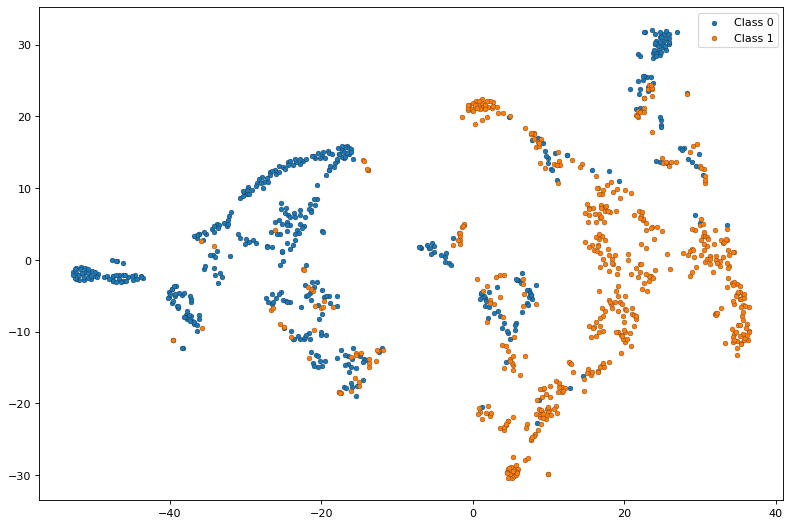

In [ ]:
model_name=r'gat_000511.pth'  # This model is checked-in, feel free to use the one you trained
dataset_name=DatasetType.HOME_NETWORK.name


visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)

Beautiful!

What we can see is the following - once we do a forward pass through GAT it transforms the input feature vectors of dimension (number of nodes, number of features per feature vector) = `(2708, 1433)` into `(2708, 7)` because Cora has 7 classes.

The classes are: `Genetic Algorithms`, `Reinforcement Learning`, etc. to make it a bit less abstract but ultimately it doesn't matter it would work for any set of 7 classes (People who subscribe to [The AI Epiphany](https://www.youtube.com/c/TheAIEpiphany), *people who.., I'll stop here*).

Now once we've got those 7 dimensional vectors we use t-SNE to map them into 2D vectors (*because it's hard to plot 7D vectors you know*). The trick with t-SNE is that it preserves the relationships betweeen the vectors so, roughly, if they were close (however we define the "closeness") in the 7D space they'll be close in the 2D space as well.

Now you can see that points of the same class (they share the same color) are clustered together! And that's a desirable property because now it's much easier to train a classifier that'll correctly predict the class.

---

Awesome, now let's switch our focus to attention since we're dealing with Graph **Attention** Network after all.

# Visualizing neighborhood attention 📣

So, you now hopefully understand how GAT roughly works, and so you know that during the aggregation stage every single node assigns an **attention coefficient** to every single one of its neighbors (including itself since we added self edges).

Any ideas on what we could visualize? Well let's pick some nodes and see which attention patterns they've learned!

The first idea that may pop to your mind is to draw edges **thicker** if the **attention is larger** and vice versa (*well that's also the last idea that pops to my mind*).

Let's do it!

In [ ]:
# Again, unfortunately, igraph is having some problems running in Jupyter so I have to flatten out the content here
# including the for loops - no for loops with igraph in Jupyter folks.

# Fetch the data we'll need to create visualizations
all_nodes_unnormalized_scores, edge_index, node_labels, gat, num_classes = gat_forward_pass(model_name, dataset_name, config)

# The number of nodes for which we want to visualize their attention over neighboring nodes
num_nodes_of_interest = 4  # 4 is an arbitrary number you can play with these numbers
head_to_visualize = 0  # plot attention from this multi-head attention's head (last layer only has a single head)
gat_layer_id = 1  # plot attention from this GAT layer (since our GAT only has 2 layers this is the last layer)

# Build up the complete graph
# node_features shape = (N, FIN), where N is the number of nodes and FIN number of input features
total_num_of_nodes = len(node_features)
complete_graph = ig.Graph()
complete_graph.add_vertices(total_num_of_nodes)  # igraph creates nodes with ids [0, total_num_of_nodes - 1]
edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :]))  # igraph requires this format
complete_graph.add_edges(edge_index_tuples)

# Pick the target nodes to plot (nodes with highest degree + random nodes)
# Note: there could be an overlap between random nodes and nodes with highest degree - but highly unlikely
highest_degree_node_ids = np.argpartition(complete_graph.degree(), -num_nodes_of_interest)[-num_nodes_of_interest:]
random_node_ids = np.random.randint(low=0, high=total_num_of_nodes, size=num_nodes_of_interest)

print(f'Highest degree nodes = {highest_degree_node_ids}')

target_node_ids = edge_index[1]
source_nodes = edge_index[0]

# Pick the node id you want to visualize the attention for!
target_node_id = 306  # 306 is the 2nd highest degree node

# Step 1: Find the neighboring nodes to the target node
src_nodes_indices = torch.eq(target_node_ids, target_node_id)
source_node_ids = source_nodes[src_nodes_indices].cpu().numpy()
size_of_neighborhood = len(source_node_ids)

# Ensure target_node_id is in the source_node_ids
if target_node_id not in source_node_ids:
    source_node_ids = np.append(source_node_ids, target_node_id)
    size_of_neighborhood += 1

# Step 2: Fetch their labels
labels = node_labels[source_node_ids].cpu().numpy()

# Step 3: Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
# attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
all_attention_weights = gat.gat_net[gat_layer_id].attention_weights.squeeze(dim=-1)
attention_weights = all_attention_weights[src_nodes_indices, head_to_visualize].cpu().numpy()
print(f'Max attention weight = {np.max(attention_weights)} and min = {np.min(attention_weights)}')
attention_weights /= np.max(attention_weights)  # rescale the biggest weight to 1 for nicer plotting

# Build up the neighborhood graph whose attention we want to visualize
id_to_igraph_id = dict(zip(source_node_ids, range(len(source_node_ids))))
ig_graph = ig.Graph()
ig_graph.add_vertices(size_of_neighborhood)
ig_graph.add_edges([(id_to_igraph_id[neighbor], id_to_igraph_id[target_node_id]) for neighbor in source_node_ids])

# Prepare the visualization settings dictionary and plot
visual_style = {
    "edge_width": attention_weights,  # make edges as thick as the corresponding attention weight
    "layout": ig_graph.layout_reingold_tilford_circular()  # layout for tree-like graphs
}
# This is the only part that's specific to the dataset
if dataset_name.lower() == DatasetType.HOME_NETWORK.name.lower():
    visual_style["vertex_color"] = [home_network_label_to_color_map[label] for label in labels]
else:
    print('Add custom color scheme for your specific dataset. Using igraph default coloring.')

ig.plot(ig_graph, **visual_style)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Highest degree nodes = [ 5574 11072  4867  8202]
Max attention weight = 1.0 and min = 1.0


AttributeError: Plotting not available; please install pycairo or cairocffi

Beautiful! 🎉😍

But have you noticed anything, let's call it, weird? All the edges have the same thickness? What's up with that?

Well it turns out that on Cora constant attention i.e. the same attention coefficients over the neighborhood does a great job.

On some different graph dataset that is not `homophilic` we'd have more interesting attention patterns - check out the other script for PPI.

But until then, there is one more way to understand whether GAT is learning interesting attention patterns, and that brings us to entropy histograms!

# Visualizing entropy histograms 📊

So, I hear you say, wait `entropy`, what? How did [Claude Shannon](http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) find his way in?

Well it's not that hard. The attention coefficients sum up to 1 - they form a probability distribution. Where there is a probability distribution you can calculate the entropy. And the entropy quantifies the amount of information in a distribution (for my uber geeks - it's an expected value of self-information 🤓).

Check out this [amazing video](https://www.youtube.com/watch?v=ErfnhcEV1O8) if you're not familiar with the concept of entropy, but actually you don't need to understand the theory of entropy so much in order to understand why we're doing this.

The main idea is the following:

If we have a **"hypothetical" GAT** that has a const attention over every node's neighborhood (i.e. **all distributions are uniform**), and we calculate the entropy (whatever that may be) of each and every neighborhood, and we make a histogram out of those numbers - **how different are the histograms** coming from it compared to the GAT we just trained?

If the answer is they completely overlap, well that means our GAT has got uniform attention patterns. The smaller the overlap the less uniform the distributions are. We don't care about the information, per se, we care about how much the histograms **match**.

Helpfully that brings some clarity into your mind. With that out of the way let's visualize the damn thing:

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


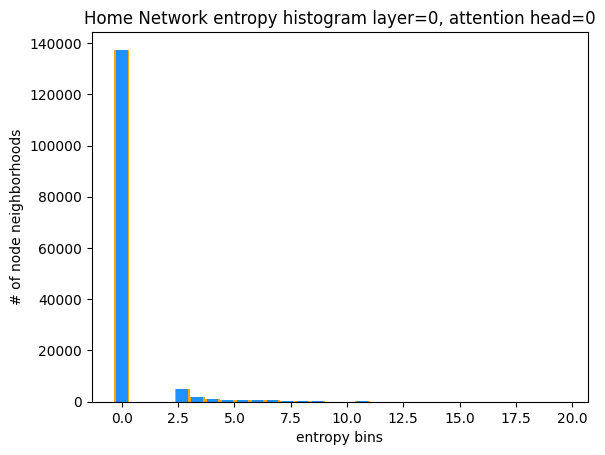

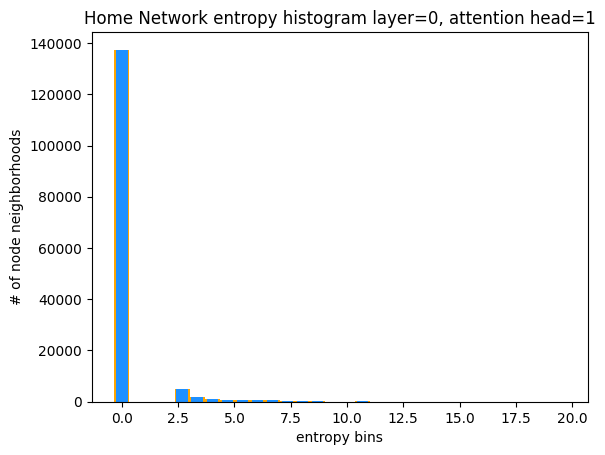

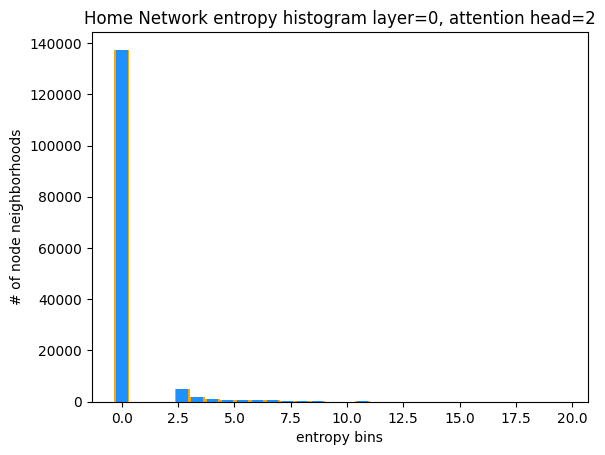

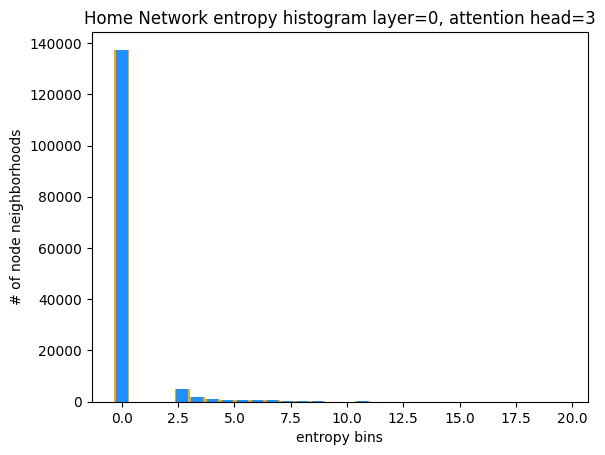

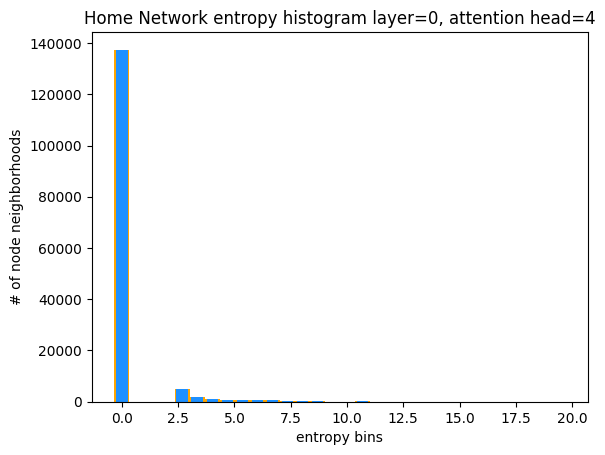

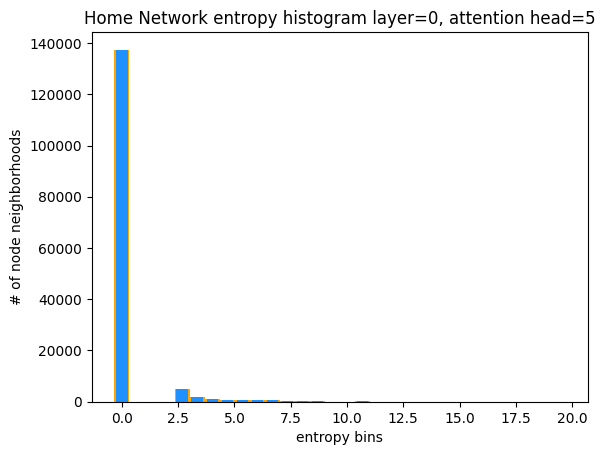

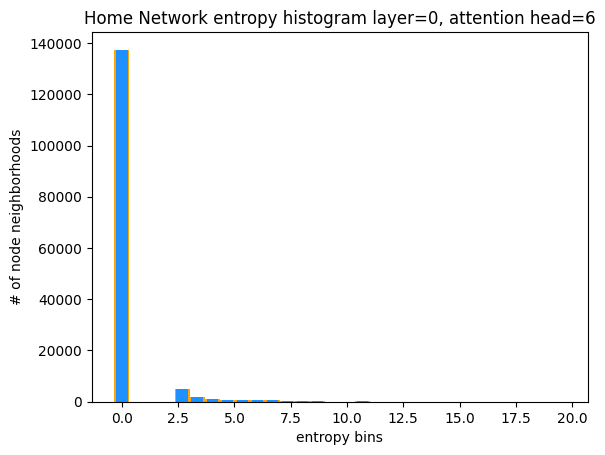

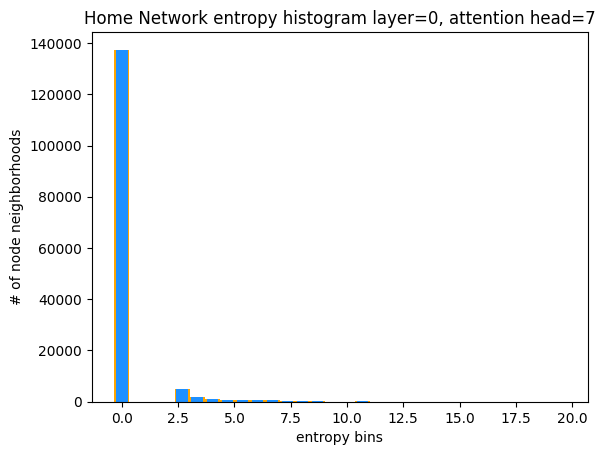

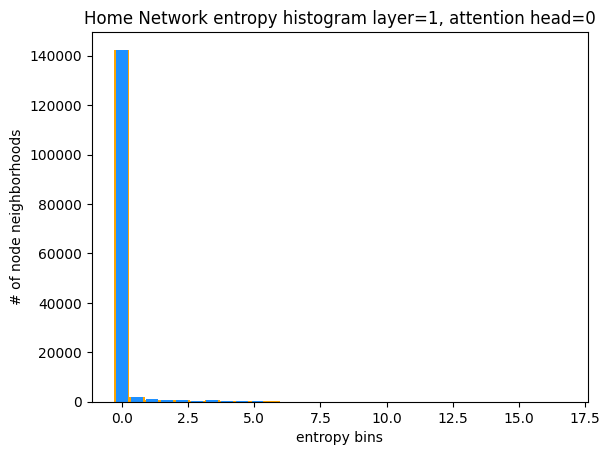

In [ ]:
visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.ENTROPY  # pick between attention, t-SNE embeddings and entropy
)

And voilà, the light blue histograms (trained GAT) completely match the orange ones (uniform attention GAT).

If the previous visualization with edge thickness plotted didn't convince you I'm sure that entropy will! (*laughs in kilo bits per cringe*)

The idea for this visualization came from [this blog post](https://www.dgl.ai/blog/2019/02/17/gat.html) recommended to me by Petar Veličković.

---

Phew!!! That was a mouthful! If you stayed with me until here, **congrats!** (achievement unlocked - GAT master 😍)

Take your time to analyze this notebook. This is not a toy project, it took me ~3 weeks to finish it <br/>
so don't expect to understand everything in 30 minutes unless you're really familiar with most of the concepts mentioned here.

And last but not least!

# Connect with me

I share lots of useful (I hope so at least!) content on LinkedIn, Twitter, YouTube and Medium. <br/>
So feel free to connect with me there:
1. My [LinkedIn](https://www.linkedin.com/in/aleksagordic) and [Twitter](https://twitter.com/gordic_aleksa) profiles
2. My YouTube channel - [The AI Epiphany](https://www.youtube.com/c/TheAiEpiphany)
3. My [Medium](https://gordicaleksa.medium.com/) profile

Also do drop me a message if you found this useful or if you think I could've done something better! <br/>
I always like getting some feedback on the work I do.

If you notice some bugs/errors feel free to **open up an issue** or even **submit a pull request**.

# Additional resources

If you're interested in learning more about GNNs there are many awesome resources out there.

* Check out [Sergey Ivanov's newsletter](https://graphml.substack.com/p/issue-1-introduction-pac-isometry-over-smoothing-and-evolution-of-the-field-265283)
* [Michael Bronstein's](https://medium.com/@michael.bronstein) blog posts

And of course watch my videos:
* [My overview of the GCN paper](https://www.youtube.com/watch?v=VyIOfIglrUM)
* [My overview of the GraphSAGE paper](https://www.youtube.com/watch?v=vinQCnizqDA)
* [My overview of the PinSage paper](https://www.youtube.com/watch?v=ed0NJdqwEyg)
* [My overview of Temporal Graph Networks (TGN)](https://www.youtube.com/watch?v=0tw66aTfWaI)

Also, follow GNN experts on Twitter. That's a good strategy to stay in touch with the field. Check out the people I follow that's better than me cherry-picking some names here.

*Note: I didn't do it justice by only linking Michael and Sergey - I'll probably create a video where I'll explain how I approached learning about GNNs and various different resources I leveraged.*